## **1. Importación de datos**

En este paso se utilizó la librería **pandas** para leer el archivo `Calificaciones.csv`.  
Después se imprimieron los tipos de datos de cada columna para identificar cuáles son numéricos y cuáles categóricos.  
Esto es importante porque los modelos de regresión solo pueden trabajar con variables numéricas.


In [3]:
import pandas as pd

df = pd.read_csv("A1.5 Calificaciones.csv")
df.head()

,Escuela,Sexo,Edad,HorasDeEstudio,Reprobadas,Internet,Faltas,G1,G2,G3
0,GP,F,18,2,0,no,6,5,6,6
1,GP,F,17,2,0,yes,4,5,5,6
2,GP,F,15,2,3,yes,10,7,8,10
3,GP,F,15,3,0,yes,2,15,14,15
4,GP,F,16,2,0,no,4,6,10,10


## **2. Transformación de variables categóricas**
Las variables categóricas como **Sexo**, **Escuela** e **Internet** fueron transformadas utilizando `pd.get_dummies()`.  
De esta manera, cada categoría se convierte en una columna binaria (0 o 1), lo cual permite que el modelo de regresión lineal pueda utilizarlas como predictores.  
Se imprimieron las primeras cinco observaciones para comprobar que ya no existen variables de tipo texto.


In [4]:
df_mod = pd.get_dummies(df, drop_first="True")
df_mod.head()

,Edad,HorasDeEstudio,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes
0,18,2,0,6,5,6,6,False,False,False
1,17,2,0,4,5,5,6,False,False,True
2,15,2,3,10,7,8,10,False,False,True
3,15,3,0,2,15,14,15,False,False,True
4,16,2,0,4,6,10,10,False,False,False


## **3. Identificación de valores atípicos**
Para la variable **Faltas**, se aplicó el método de **Tukey con k=3**.  
Se calcularon los cuartiles (Q1 y Q3), el rango intercuartílico (IQR), y se establecieron límites inferior y superior.  
Las observaciones fuera de estos límites se marcaron como atípicas.  
Después se decidió si se eliminaban o mantenían, justificando la decisión en función de si afectaban o no al modelo.


In [5]:
Q1 = df_mod['Faltas'].quantile(0.25)
Q3 = df_mod['Faltas'].quantile(0.75)
IQR = Q3 - Q1

lim_inf = Q1 - 3*IQR
lim_sup = Q3 + 3*IQR

outliers = df_mod[(df_mod['Faltas'] < lim_inf) | (df_mod['Faltas'] > lim_sup)]
print(outliers)

     Edad  HorasDeEstudio  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  \
74     16               2           0      54  11  12  11       False   False   
183    17               2           0      56   9   9   8       False   False   
276    18               2           0      75  10   9   9       False   False   
307    19               1           1      38   8   9   8       False    True   
315    19               3           1      40  13  11  11       False   False   

     Internet_yes  
74           True  
183          True  
276          True  
307          True  
315          True  


## **4. Matriz de correlación y heatmap**
Se calculó la matriz de correlación de Pearson entre todas las variables y se representó gráficamente con un **heatmap** usando seaborn.  
Esto permitió identificar posibles problemas de **colinealidad**, como en el caso de **G1, G2 y G3**, que muestran correlaciones muy altas entre sí.  
En este punto se evaluó si era necesario eliminar alguna variable para mejorar la estabilidad del modelo.

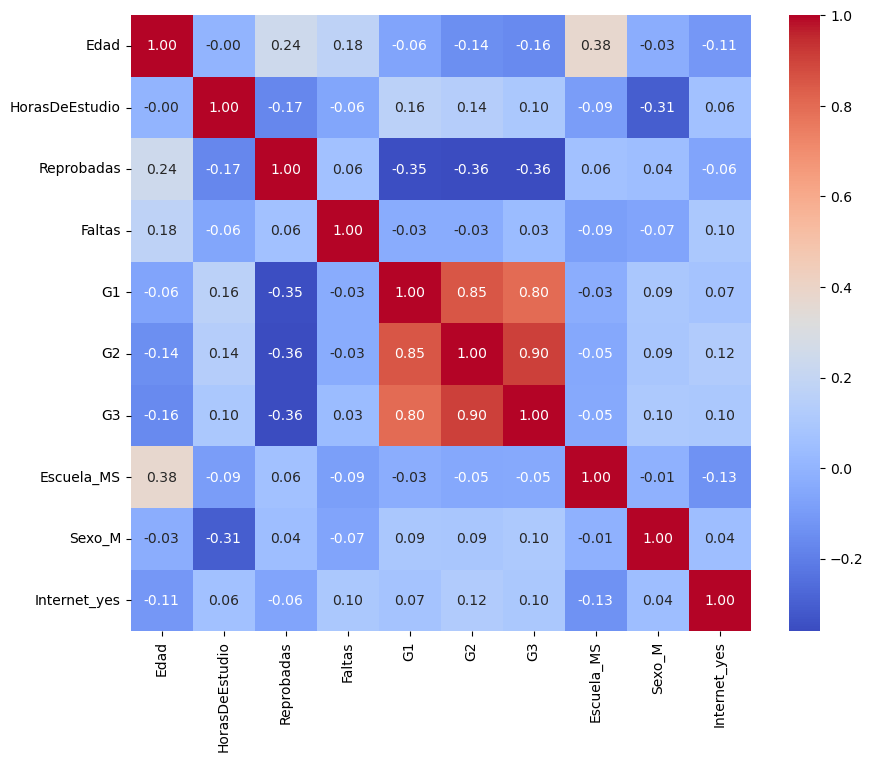

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_mod.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

## **5. Inclusión de términos de interacción**
Se agregaron nuevas variables de interacción entre pares que podrían tener un efecto combinado en el desempeño del estudiante, por ejemplo:  
- **G1 * Internet_yes**  
- **HorasDeEstudio * Reprobadas**  

Esto enriquece el modelo al capturar relaciones más complejas que no se reflejan únicamente con los efectos individuales.

In [8]:
df_mod["Interaccion_G1_Internet"] = df_mod["G1"] * df_mod["Internet_yes"]
df_mod["Interaccion_Horas_Reprobadas"] = df_mod["HorasDeEstudio"] * df_mod["Reprobadas"]

df_mod.head()

,Edad,HorasDeEstudio,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,Interaccion_G1_Internet,Interaccion_Horas_Reprobadas
0,18,2,0,6,5,6,6,False,False,False,0,0
1,17,2,0,4,5,5,6,False,False,True,5,0
2,15,2,3,10,7,8,10,False,False,True,7,6
3,15,3,0,2,15,14,15,False,False,True,15,0
4,16,2,0,4,6,10,10,False,False,False,0,0


## **6. Entrenamiento y validación del modelo**
Se dividió la base de datos en dos subconjuntos:  
- **80% para entrenamiento**  
- **20% para prueba**  

Posteriormente se entrenó un **modelo de regresión lineal múltiple** y se evaluó en el conjunto de prueba.  
Se generó una gráfica de dispersión entre las calificaciones finales reales (**G3**) y las calificaciones predichas, donde se observa que los puntos se alinean bastante bien en torno a una diagonal.  

Además, se calcularon dos métricas principales:  
- **R² = 0.78** → El modelo explica aproximadamente el **78% de la variabilidad** en la calificación final.  
- **MSE ≈ 4.49** → El error cuadrático medio indica que, en promedio, las predicciones se desvían unas **2 unidades** de la escala original (0 a 20).


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_mod.drop("G3", axis=1)
y = df_mod["G3"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Resultados
y_pred = model.predict(X_test)

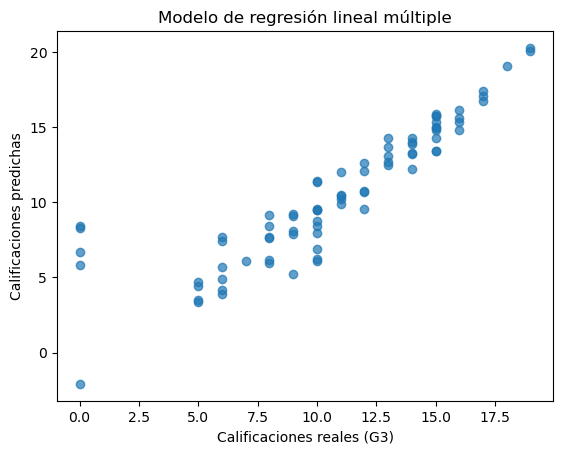

R2: 0.7807140440488959
MSE: 4.496468892000433


In [10]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Calificaciones reales (G3)")
plt.ylabel("Calificaciones predichas")
plt.title("Modelo de regresión lineal múltiple")
plt.show()

print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

## **Conclusión**
El modelo de regresión lineal múltiple desarrollado muestra un **buen desempeño predictivo**, explicando gran parte de la variabilidad en la calificación final (**G3**).  
Las variables más influyentes resultaron ser las calificaciones de los periodos previos (**G1 y G2**), lo cual es consistente con la lógica académica: el rendimiento pasado es un fuerte predictor del rendimiento futuro.  

Aunque el modelo no es perfecto (MSE distinto de 0 y algunos puntos alejados de la diagonal en la gráfica), los resultados obtenidos son satisfactorios y útiles para predecir el desempeño final de los estudiantes a partir de su información previa.
